# Домашнее задание 5. Обучение U-net

В этом задании вам предлагается обучить U-net для сегментации автомобилей. Подобная задача может быть актуальной для маркетплейсов, когда требуется отделить товар от фона, на котором он сфотографирован. Задание включает в себя:



1.   Загрузку и предобработку датасета из kaggle;
2.   Определение архитектуры U-net;
3.   Настройку пайплайна обучения.





## 1. Датасет

Мы воспользуеся датасетом [Carvana](https://www.kaggle.com/competitions/carvana-image-masking-challenge/overview), который уже содержит необходимые изображения и маски. Чтобы получить доступ к датасету, необходимо 1) зарегистрироваться на kaggle, 2) сгенерировать ключ, 3) вступить в соревнование, 4) загрузить датасет через kaggle API

In [1]:
!pip install albumentations

In [2]:
# Откатим версию библиотеки kaggle чтобы не было ошибки KeyError: 'username'
!pip install kaggle==1.6.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105787 sha256=4c4f9d4d6ba91c10ffb35d882a335ccc6a6abff31c186723ceef01d6033f6ca6
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
import zipfile
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import cv2

**Получение ключа API**

1. Зарегистрироваться на платформе https://www.kaggle.com/  

2. Получить API ключ
`Kaggle` - `Settings` - `Create New API Token`  

В результате будет произведена загрузка файла `kaggle.json`, который состоит из двух значений - имя пользователя и сам API токен  
```
{"username":"имя_пользователя","key":"API_токен"}
```

Закинуть `kaggle.json` в раздел файлы в Colab

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Для скачивания возможно придется вступить в соревнование и принять правила на самой платформе Kaggle.

In [5]:
!kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [04:24<00:00, 155MB/s]
100% 24.4G/24.4G [04:24<00:00, 99.1MB/s]


In [6]:
# Распакуем carvana-image-masking-challenge.zip
zip_file_path = '/content/carvana-image-masking-challenge.zip'
destination_folder = '/content/extracted_content'

try:
    with ZipFile(zip_file_path, 'r') as zip_ref:
        print(f"Extracting all files from '{zip_file_path}' to '{destination_folder}'...")
        zip_ref.extractall(destination_folder)
        print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Extracting all files from '/content/carvana-image-masking-challenge.zip' to '/content/extracted_content'...
Extraction complete.


In [ ]:
# Распакуем train.zip
zip_file_train_path = 'train.zip'

try:
    with ZipFile(zip_file_train_path, 'r') as zip_ref:
        print(f"Extracting all files from '{zip_file_train_path}' to '{destination_folder}'...")
        zip_ref.extractall(destination_folder)
        print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_train_path}' was not found.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Extracting all files from 'train.zip' to '/content/extracted_content'...
Extraction complete.


In [8]:
# Распакуем train_masks.zip
zip_file_train_masks_path = '/content/extracted_content/train_masks.zip'

try:
    with ZipFile(zip_file_train_masks_path, 'r') as zip_ref:
        print(f"Extracting all files from '{zip_file_train_masks_path}' to '{destination_folder}'...")
        zip_ref.extractall(destination_folder)
        print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_train_masks_path}' was not found.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Extracting all files from '/content/extracted_content/train_masks.zip' to '/content/extracted_content'...
Extraction complete.


In [ ]:
images_dir = "/content/extracted_content/train"
masks_dir = "/content/extracted_content/train_masks"

Кол-во картинок в папке: 5088
[Image] 00087a6bd4dc_01.jpg — Размер: 1918x1280, Режим: RGB
[Image] 00087a6bd4dc_02.jpg — Размер: 1918x1280, Режим: RGB
[Image] 00087a6bd4dc_03.jpg — Размер: 1918x1280, Режим: RGB


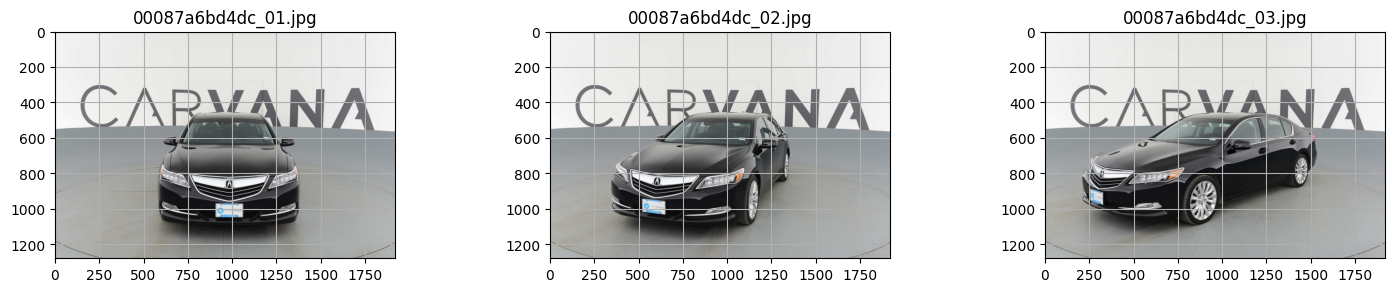

In [3]:
# Получаем список файлов в папке
image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
image_files.sort()
print(f'Кол-во картинок в папке: {len(image_files)}')

num_images_to_display = 3
plt.figure(figsize=(15, 3))

for i in range(min(num_images_to_display, len(image_files))):
    image_path = os.path.join(images_dir, image_files[i])
    try:
        img = Image.open(image_path)
        width, height = img.size
        mode = img.mode
        print(f"[Image] {image_files[i]} — Размер: {width}x{height}, Режим: {mode}")
        
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(img)
        plt.title(image_files[i])
        plt.grid()
    except Exception as e:
        print(f"Ошибка при открытии изображения {image_files[i]}: {e}")
        continue

plt.tight_layout()
plt.show()

Кол-во масок в папке: 5088
[Mask] 00087a6bd4dc_01_mask.gif — Размер: 1918x1280, Режим: P
[Mask] 00087a6bd4dc_02_mask.gif — Размер: 1918x1280, Режим: P
[Mask] 00087a6bd4dc_03_mask.gif — Размер: 1918x1280, Режим: P


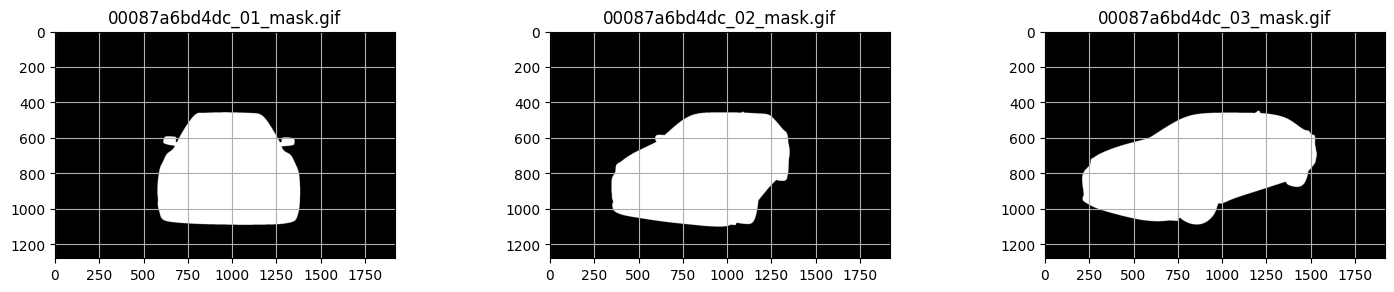

In [4]:
# Получаем список файлов в папке
mask_files = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]
mask_files.sort()
print(f'Кол-во масок в папке: {len(mask_files)}')

num_mask_to_display = 3
plt.figure(figsize=(15, 3))

for i in range(min(num_mask_to_display, len(mask_files))):
    mask_path = os.path.join(masks_dir, mask_files[i])
    try:
        img = Image.open(mask_path)
        
        # Для .gif важно учесть, что они могут быть многокадровыми
        img.seek(0)  # Выбираем первый кадр
        width, height = img.size
        mode = img.mode
        print(f"[Mask] {mask_files[i]} — Размер: {width}x{height}, Режим: {mode}")
        
        plt.subplot(1, num_mask_to_display, i + 1)
        plt.imshow(img)
        plt.title(mask_files[i])
        plt.grid()
    except Exception as e:
        print(f"Ошибка при открытии маски {mask_files[i]}: {e}")
        continue

plt.tight_layout()
plt.show()

Виды *mode*:

- RGB — 3 канала (цветное изображение),

- L — 1 канал (grayscale),

- P — палитровое изображение (часто в .gif),

- RGBA — 4 канала (цвет + прозрачность),

- I;16 — 16-битное изображение.

### 1.2 Аугментации через albumentations

В обучении U-net большую роль играет аугментация данных. Широкий набор нестандартных операций реализованы в библиотеке [albumentations](https://albumentations.ai/docs/2-core-concepts/transforms/). Вы можете ознакомиться с ней и добавить понравившиеся трансформации ниже в функцию *get_train_transform*

In [5]:
def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=10, p=0.2),
        A.Rotate(limit=20),
        A.Normalize(mean=(0.5,) * 3, std=(0.5,) * 3),
        ToTensorV2()
    ])

def get_val_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.5,) * 3, std=(0.5,) * 3),
        ToTensorV2()
    ])

In [6]:
def split_dataset(images_dir, val_ratio=0.2, seed=42):
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])
    train_files, val_files = train_test_split(image_files, test_size=val_ratio, random_state=seed)
    return train_files, val_files

In [7]:
class CarvanaDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_names, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        image_file = self.file_names[idx]
        image_path = os.path.join(self.images_dir, image_file)
        mask_path = os.path.join(self.masks_dir, image_file.replace('.jpg', '_mask.gif'))

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"].unsqueeze(0)  # (1, H, W)

        return image, mask

## 2. Определение U-net модели

На этом шаге от вас требуется определить структуру U-net, как, например, на картинке ниже. Для этого вам помогут операции и слои:


*   nn.Conv2d - обычная свертка
*   nn.MaxPool2d - max-pool, для уменьшения размерности activation map-ов
*   nn.ConvTranspose2d - обратная свертка
*   F.relu - функция активации
*   torch.cat - конкатинация векторов в skip connection


![img](https://lh6.googleusercontent.com/Rx30jfXZqXnWX8CjmBaztePGMtCydUyeR_D6o1o-2kVnyg2cX-yyEmwYheeWJR2vxEAepYromNrriGyLeGuZatztKdCYCmiIrsSspW75EX9WxvOivLPKxfwkIvQji9MzJIHK0y5V)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_classes=1):
        super(UNet, self).__init__()
        # — входной блок: 2 × Conv + ReLU
        self.inc_conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.inc_relu1 = nn.ReLU(inplace=True)
        self.inc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.inc_relu2 = nn.ReLU(inplace=True)

        # — блоки «вниз»: MaxPool2d → 2×(Conv + ReLU)
        self.down1_pool  = nn.MaxPool2d(2)
        self.down1_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.down1_relu1 = nn.ReLU(inplace=True)
        self.down1_conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.down1_relu2 = nn.ReLU(inplace=True)

        self.down2_pool  = nn.MaxPool2d(2)
        self.down2_conv1 = nn.Conv2d(128, 256, 3, padding=1)
        self.down2_relu1 = nn.ReLU(inplace=True)
        self.down2_conv2 = nn.Conv2d(256, 256, 3, padding=1)
        self.down2_relu2 = nn.ReLU(inplace=True)

        self.down3_pool  = nn.MaxPool2d(2)
        self.down3_conv1 = nn.Conv2d(256, 512, 3, padding=1)
        self.down3_relu1 = nn.ReLU(inplace=True)
        self.down3_conv2 = nn.Conv2d(512, 512, 3, padding=1)
        self.down3_relu2 = nn.ReLU(inplace=True)

        self.down4_pool  = nn.MaxPool2d(2)
        self.down4_conv1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.down4_relu1 = nn.ReLU(inplace=True)
        self.down4_conv2 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.down4_relu2 = nn.ReLU(inplace=True)

        # — блоки «вверх»: ConvTranspose2d → concat → 2×(Conv + ReLU)
        self.up1_trans   = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up1_conv1   = nn.Conv2d(1024, 512, 3, padding=1)
        self.up1_relu1   = nn.ReLU(inplace=True)
        self.up1_conv2   = nn.Conv2d(512, 512, 3, padding=1)
        self.up1_relu2   = nn.ReLU(inplace=True)

        self.up2_trans   = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2_conv1   = nn.Conv2d(512, 256, 3, padding=1)
        self.up2_relu1   = nn.ReLU(inplace=True)
        self.up2_conv2   = nn.Conv2d(256, 256, 3, padding=1)
        self.up2_relu2   = nn.ReLU(inplace=True)

        self.up3_trans   = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3_conv1   = nn.Conv2d(256, 128, 3, padding=1)
        self.up3_relu1   = nn.ReLU(inplace=True)
        self.up3_conv2   = nn.Conv2d(128, 128, 3, padding=1)
        self.up3_relu2   = nn.ReLU(inplace=True)

        self.up4_trans   = nn.ConvTranspose2d(128, 64,  kernel_size=2, stride=2)
        self.up4_conv1   = nn.Conv2d(128, 64, 3, padding=1)
        self.up4_relu1   = nn.ReLU(inplace=True)
        self.up4_conv2   = nn.Conv2d(64, 64, 3, padding=1)
        self.up4_relu2   = nn.ReLU(inplace=True)

        # — финальный 1×1 Conv
        self.outc = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        # — входной блок
        x1 = self.inc_relu1(self.inc_conv1(x))
        x1 = self.inc_relu2(self.inc_conv2(x1))

        # — вниз 1
        x2 = self.down1_pool(x1)
        x2 = self.down1_relu1(self.down1_conv1(x2))
        x2 = self.down1_relu2(self.down1_conv2(x2))

        # — вниз 2
        x3 = self.down2_pool(x2)
        x3 = self.down2_relu1(self.down2_conv1(x3))
        x3 = self.down2_relu2(self.down2_conv2(x3))

        # — вниз 3
        x4 = self.down3_pool(x3)
        x4 = self.down3_relu1(self.down3_conv1(x4))
        x4 = self.down3_relu2(self.down3_conv2(x4))

        # — вниз 4 (bottleneck)
        x5 = self.down4_pool(x4)
        x5 = self.down4_relu1(self.down4_conv1(x5))
        x5 = self.down4_relu2(self.down4_conv2(x5))

        # — вверх 1
        u1 = self.up1_trans(x5)
        u1 = torch.cat([u1, x4], dim=1)
        u1 = self.up1_relu1(self.up1_conv1(u1))
        u1 = self.up1_relu2(self.up1_conv2(u1))

        # — вверх 2
        u2 = self.up2_trans(u1)
        u2 = torch.cat([u2, x3], dim=1)
        u2 = self.up2_relu1(self.up2_conv1(u2))
        u2 = self.up2_relu2(self.up2_conv2(u2))

        # — вверх 3
        u3 = self.up3_trans(u2)
        u3 = torch.cat([u3, x2], dim=1)
        u3 = self.up3_relu1(self.up3_conv1(u3))
        u3 = self.up3_relu2(self.up3_conv2(u3))

        # — вверх 4
        u4 = self.up4_trans(u3)
        u4 = torch.cat([u4, x1], dim=1)
        u4 = self.up4_relu1(self.up4_conv1(u4))
        u4 = self.up4_relu2(self.up4_conv2(u4))

        # — итоговый выход
        logits = self.outc(u4)
        return logits

## 3. Обучение U-net

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
model = UNet(in_channels=3, out_classes=1).to(device)
model

UNet(
  (inc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inc_relu1): ReLU(inplace=True)
  (inc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inc_relu2): ReLU(inplace=True)
  (down1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1_relu1): ReLU(inplace=True)
  (down1_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1_relu2): ReLU(inplace=True)
  (down2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2_conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down2_relu1): ReLU(inplace=True)
  (down2_conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down2_relu2): ReLU(inplace=True)
  (down3_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3_

In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def create_data_loader(images_dir, masks_dir, file_names, batch_size=4, train=True):
    transform = get_train_transform() if train else get_val_transform()
    dataset = CarvanaDataset(images_dir, masks_dir, file_names, transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=train, num_workers=0)

In [13]:
train_files, val_files = split_dataset(images_dir)

train_loader = create_data_loader(images_dir, masks_dir, train_files, batch_size=4, train=True)
val_loader = create_data_loader(images_dir, masks_dir, val_files, batch_size=4, train=False)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples: {len(val_loader.dataset)}")

Train samples: 4070
Val samples: 1018


## 4. Оценка модели


В качестве метрики, оценивающей модель, воспользуемся [коэффициентом  Сёренсена](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%A1%D1%91%D1%80%D0%B5%D0%BD%D1%81%D0%B5%D0%BD%D0%B0), или Dice coefficient. Коэффициент Сёренсена можно использовать для сравнения попиксельного соответствия между прогнозируемой сегментацией и соответствующей ей истинной информацией.

Dice Similarity Coefficient (DSC) или Мера Сёренсена — бинарная мера сходства — мера перекрытия между предсказанной маской и истинной (ground truth).
Её формула:

$$
Dice = \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$

где:

A — предсказанная бинарная маска,

B — истинная маска.

То есть:

Dice = 1.0 → идеальное совпадение,

Dice = 0.0 → нет пересечений.

In [14]:
def dice_coeff(pred, target, threshold=0.5, eps=1e-6):

    # Применим сигмоиду и порог для получения бинарных предсказаний
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()

    # Сглаживание тензоров
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    # Вычислеие Dice
    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)

    dice = (2 * intersection + eps) / (union + eps)  # защита от деления на 0
    return dice.mean()  # усреднение по батчам.

In [16]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device,
                num_epochs=15, model_path="best_model.pth"):

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

        for images, masks in train_bar:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss = 0
        val_dice = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

        with torch.no_grad():
            for images, masks in val_bar:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                dice = dice_coeff(outputs, masks)

                val_loss += loss.item()
                val_dice += dice

                val_bar.set_postfix(loss=f"{loss.item():.4f}", dice=f"{dice:.4f}")

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)

        tqdm.write(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f}")

        # Сохранение лучшей модели
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            tqdm.write(f"Saved best model (val_loss={avg_val_loss:.4f}, dice={avg_val_dice:.4f})")

    tqdm.write("Training complete.")

In [17]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10,
    model_path="best_model.pth"
)

Epoch 1/10 | Train Loss: 0.1385 | Val Loss: 0.0384 | Val Dice: 0.9655
Saved best model (val_loss=0.0384, dice=0.9655)


Epoch 2/10 | Train Loss: 0.0338 | Val Loss: 0.0243 | Val Dice: 0.9791
Saved best model (val_loss=0.0243, dice=0.9791)


Epoch 3/10 | Train Loss: 0.0262 | Val Loss: 0.0172 | Val Dice: 0.9856
Saved best model (val_loss=0.0172, dice=0.9856)


Epoch 4/10 | Train Loss: 0.0231 | Val Loss: 0.0348 | Val Dice: 0.9704


Epoch 5/10 | Train Loss: 0.0196 | Val Loss: 0.0144 | Val Dice: 0.9872
Saved best model (val_loss=0.0144, dice=0.9872)


Epoch 6/10 | Train Loss: 0.0155 | Val Loss: 0.0287 | Val Dice: 0.9780


Epoch 7/10 | Train Loss: 0.0227 | Val Loss: 0.0137 | Val Dice: 0.9889
Saved best model (val_loss=0.0137, dice=0.9889)


Epoch 8/10 | Train Loss: 0.0124 | Val Loss: 0.0122 | Val Dice: 0.9898
Saved best model (val_loss=0.0122, dice=0.9898)


Epoch 9/10 | Train Loss: 0.0135 | Val Loss: 0.0111 | Val Dice: 0.9905
Saved best model (val_loss=0.0111, dice=0.9905)


Epoch 10/10 | Train Loss: 0.0107 | Val Loss: 0.0148 | Val Dice: 0.9872
Training complete.


In [20]:
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

UNet(
  (inc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inc_relu1): ReLU(inplace=True)
  (inc_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inc_relu2): ReLU(inplace=True)
  (down1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1_relu1): ReLU(inplace=True)
  (down1_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1_relu2): ReLU(inplace=True)
  (down2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2_conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down2_relu1): ReLU(inplace=True)
  (down2_conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down2_relu2): ReLU(inplace=True)
  (down3_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3_

## 5. Визуализация предсказанных данных

In [21]:
def denormalize_image(img_tensor):
    """
    Преобразует тензор, нормализованный с mean=0.5, std=0.5, обратно в диапазон [0, 1]
    """
    img = img_tensor.cpu().clone().numpy()
    img = img.transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    img = (img * 0.5) + 0.5       # денормализация
    img = np.clip(img, 0, 1)
    return img

def visualize_predictions(model, dataloader, device, num_samples=3):
    """
    Показывает изображения, GT маски и предсказания модели (после сигмоиды и threshold).
    """
    model.eval()
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

    for i in range(min(num_samples, images.size(0))):
        img = denormalize_image(images[i])
        mask = masks[i].squeeze().cpu().numpy()
        pred = preds[i].squeeze().cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

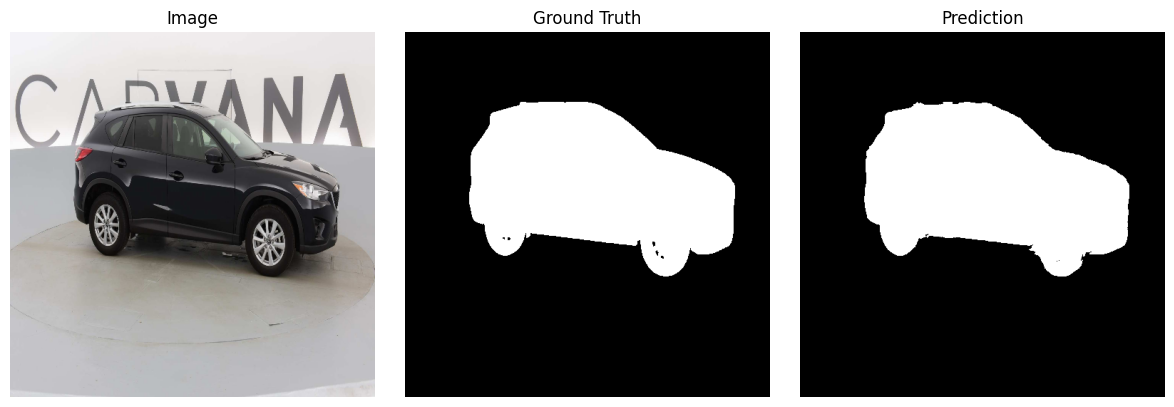

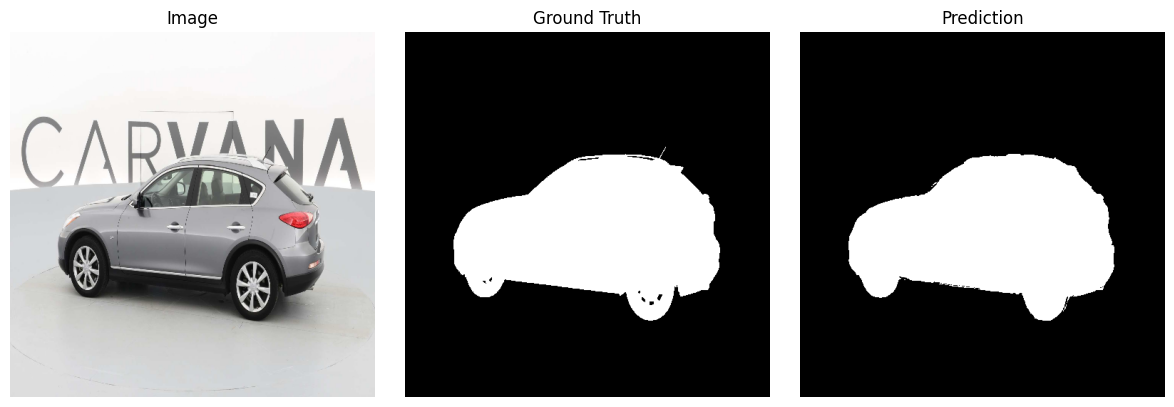

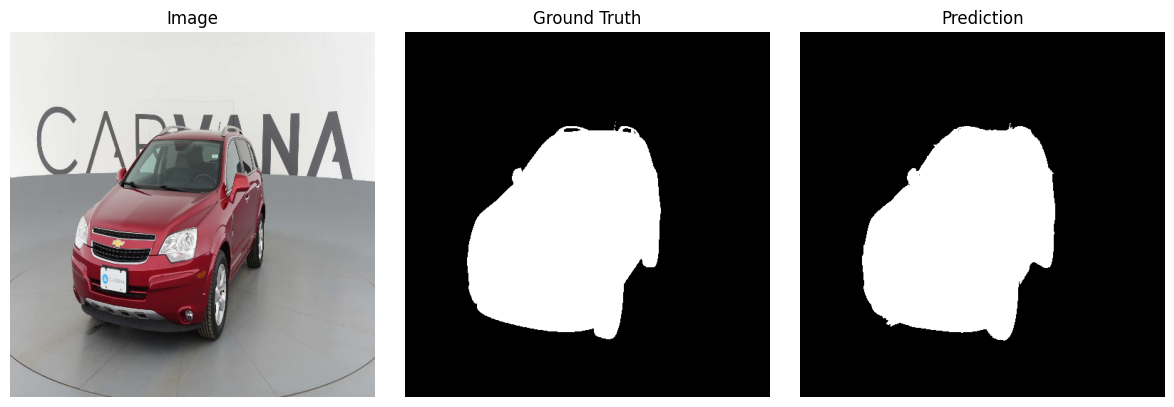

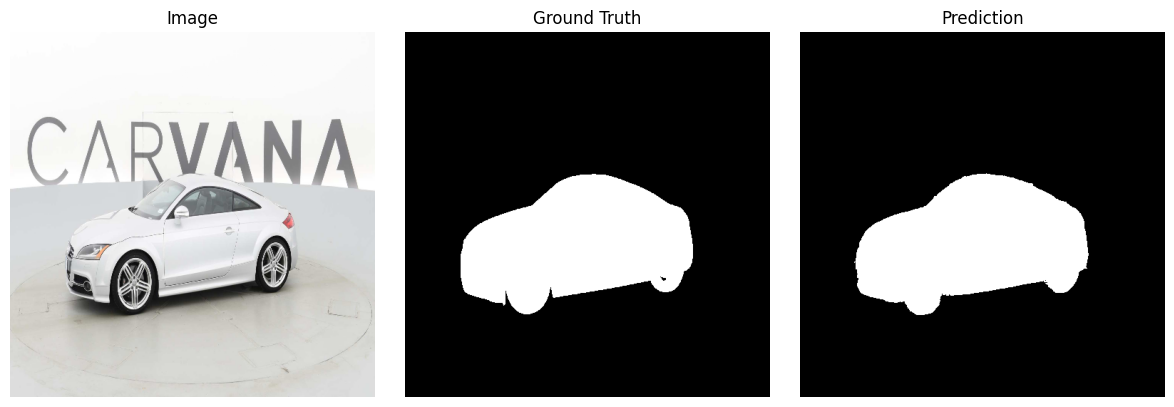

In [22]:
visualize_predictions(model, val_loader, device, num_samples=5)

In [27]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_predictions_2(model, data_loader, device, num_samples=3, threshold=0.5):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)  # переводим логиты в вероятности
            preds = (preds > threshold).float()  # бинаризуем

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                image = images[i].cpu()
                mask_true = masks[i].cpu().squeeze(0)
                mask_pred = preds[i].cpu().squeeze(0)

                # Приводим изображение обратно к [0, 1] из нормализации
                image = TF.to_pil_image((image * 0.5 + 0.5).clamp(0, 1))

                # Маски для наложения: нормализуем и накладываем цвет
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                axs[0].imshow(image)
                axs[0].set_title("Оригинал")
                axs[0].axis("off")

                axs[1].imshow(image)
                axs[1].imshow(mask_true, alpha=0.8, cmap='Reds')
                axs[1].set_title("Истинная маска")
                axs[1].axis("off")

                axs[2].imshow(image)
                axs[2].imshow(mask_pred, alpha=0.8, cmap='Blues')
                axs[2].set_title("Предсказанная маска")
                axs[2].axis("off")

                plt.tight_layout()
                plt.show()

                samples_shown += 1

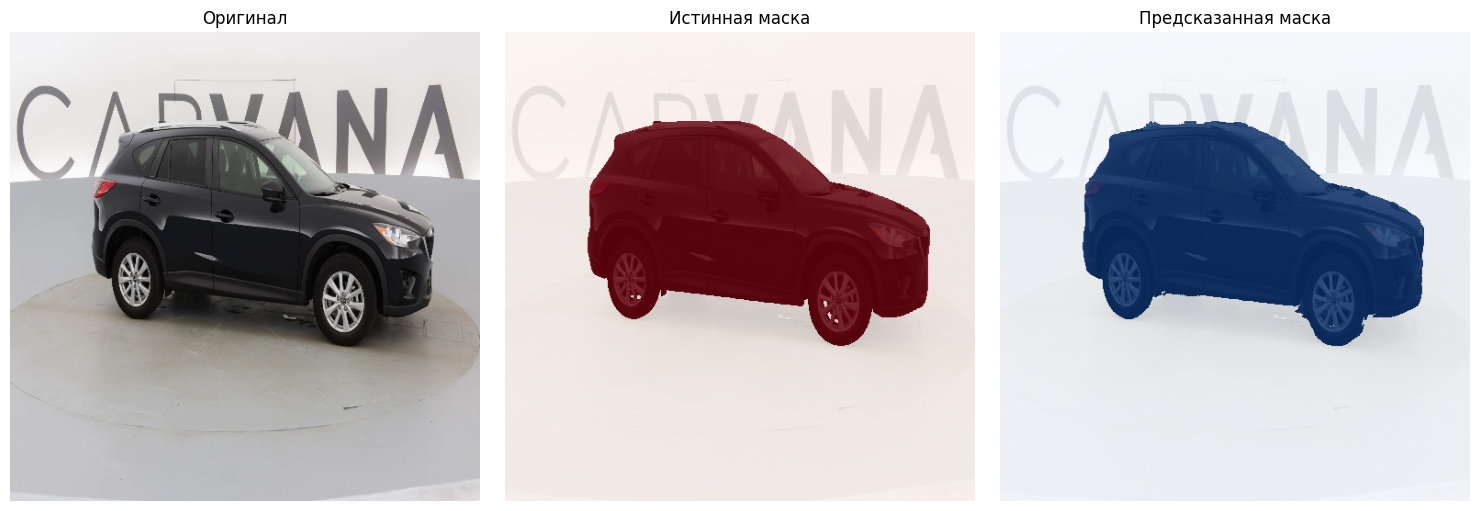

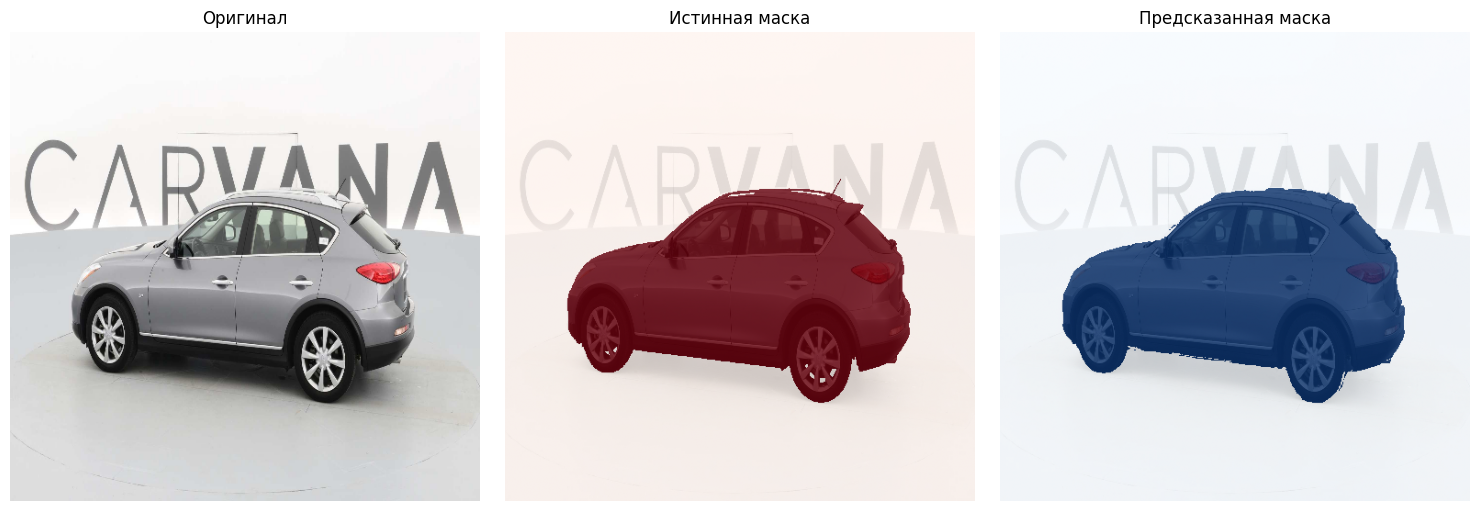

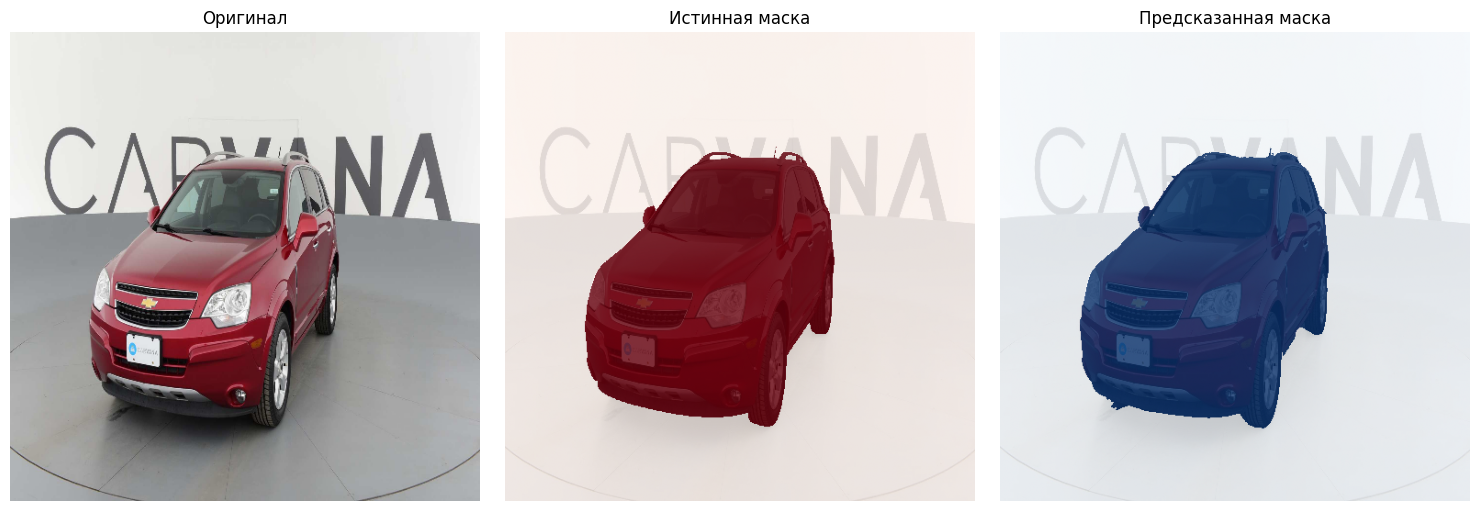

In [28]:
visualize_predictions_2(model, val_loader, device, num_samples=3, threshold=0.5)

Видим, что границы не совсем четкие, есть шумы и артефакты. Но в целом находятся границы объекта и метрика dice на валидации показала 99%. 